<h1>3) Deep Learning für Zeitreihen: Praxis, Vergleich & Anwendung</h1>
<h4>Dienstag 16.05.23 13:30 – 17:00</h4>
<br>
--- <br>
3.1 Daten vorbereiten <br>
3.2 ARIMA Vorhersage <br>
3.3 Prophet Vorhersage <br>
---

In [15]:
# Für Zeitreihenoperationen 
import pandas as pd
import numpy as np

# Zum Plotten
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Für Autokorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Für Stationarität
from statsmodels.tsa.stattools import adfuller

# Für die Datenaufbereitung
from sklearn.preprocessing import MinMaxScaler

# Für Komponentenzerlegung
from statsmodels.tsa.seasonal import seasonal_decompose

# Für ARIMA Vorhersage
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Für Prophet Vorhersage
from prophet import Prophet

# Für die Auswertung
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [16]:
# Zum Ignorieren nerviger Warnungen
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Zum GPU Teilen
#from utils_code.share_gpu import restrict_gpu_memory
#restrict_gpu_memory(4500)

### 3.1 Daten vorbereiten

Case:<br>

Wir sind Anbieter von Smart-Grid-Technologien. Unternehmen, die an der Entwicklung intelligenter Netztechnologien und -systeme beteiligt sind, verlassen sich auf Nachfrageprognosen, um die Effizienz und Stabilität des Netzes zu verbessern. Durch die genaue Vorhersage des Strombedarfs der einzelnen Verbraucher können sie intelligente Energiemanagementlösungen implementieren, Programme zur Nachfragereduzierung erleichtern und ein effektiveres Netzmanagement ermöglichen.<br>

Wir sind Analysten, die mit der Day-Ahead-Prognose beauftragt sind. Bei der Day-Ahead-Nachfrageprognose geht es um die Vorhersage des Stromverbrauchs für die nächsten 24 Stunden. Diese Prognosen sind wertvoll für den Nutzung der Energiemärkte, die Netzplanung und die Optimierung der Erzeugungs- und Übertragungsressourcen. 

In [17]:
elec = pd.read_csv("electricity.txt.gz", sep=",", header=None)
elec.columns=["Haushalt"+str(i) for i in range(1, 322)]
elec['Zeit'] = pd.date_range('2012-01-01', periods=26304, freq='h')
elec.set_index('Zeit', inplace=True)
elec.tail()

Haushalt1  Haushalt2  Haushalt3  Haushalt4  Haushalt5  \
Zeit                                                                         
2014-12-31 19:00:00       11.0      116.0        8.0      844.0      384.0   
2014-12-31 20:00:00       11.0      103.0        8.0      749.0      371.0   
2014-12-31 21:00:00       12.0       93.0        8.0      650.0      346.0   
2014-12-31 22:00:00       10.0       92.0        8.0      646.0      349.0   
2014-12-31 23:00:00       11.0       88.0        8.0      648.0      337.0   

                     Haushalt6  Haushalt7  Haushalt8  Haushalt9  Haushalt10  \
Zeit                                                                          
2014-12-31 19:00:00     1590.0       51.0     1412.0      407.0       351.0   
2014-12-31 20:00:00     1366.0       47.0     1265.0      369.0       327.0   
2014-12-31 21:00:00     1282.0       48.0     1079.0      308.0       283.0   
2014-12-31 22:00:00     1261.0       48.0     1009.0      288.0       292.0   
2014-12-31 23:00:00     1234.0       46.0     1005.0      261.0       294.0   

                     ...  Haushalt312  Haushalt313  Haushalt314  Haushalt315  \
Zeit                 ...                                                       
2014-12-31 19:00:00  ...       1897.0       1589.0     166500.0       9917.0   
2014-12-31 20:00:00  ...       1374.0       1336.0     158800.0       6812.0   
2014-12-31 21:00:00  ...        938.0       1311.0     154300.0       6602.0   
2014-12-31 22:00:00  ...        833.0       1227.0     141900.0       6546.0   
2014-12-31 23:00:00  ...        783.0       1089.0     112300.0       6188.0   

                     Haushalt316  Haushalt317  Haushalt318  Haushalt319  \
Zeit                                                                      
2014-12-31 19:00:00      10412.0        324.0         21.0       1870.0   
2014-12-31 20:00:00       8956.0        302.0         20.0       1506.0   
2014-12-31 21:00:00       5910.0        302.0         18.0       1864.0   
2014-12-31 22:00:00       5502.0        259.0         33.0       2623.0   
2014-12-31 23:00:00       4934.0        115.0         31.0       2706.0   

                     Haushalt320  Haushalt321  
Zeit                                           
2014-12-31 19:00:00        162.0       2773.0  
2014-12-31 20:00:00        438.0       2755.0  
2014-12-31 21:00:00        621.0       2650.0  
2014-12-31 22:00:00        783.0       2719.0  
2014-12-31 23:00:00        647.0       2640.0  

[5 rows x 321 columns]

Wir betrachten zunächst nur einen Haushalt.

In [18]:
em = elec[['Haushalt4']]
em.columns = ['Stromverbrauch']
em.head()

Stromverbrauch
Zeit                               
2012-01-01 00:00:00           415.0
2012-01-01 01:00:00           556.0
2012-01-01 02:00:00           560.0
2012-01-01 03:00:00           443.0
2012-01-01 04:00:00           346.0

In [19]:
time = em.index.values.reshape(-1, 1)
ema = em['Stromverbrauch'].values.reshape(-1, 1)

C:\Users\hubersi\.conda\envs\foem24\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



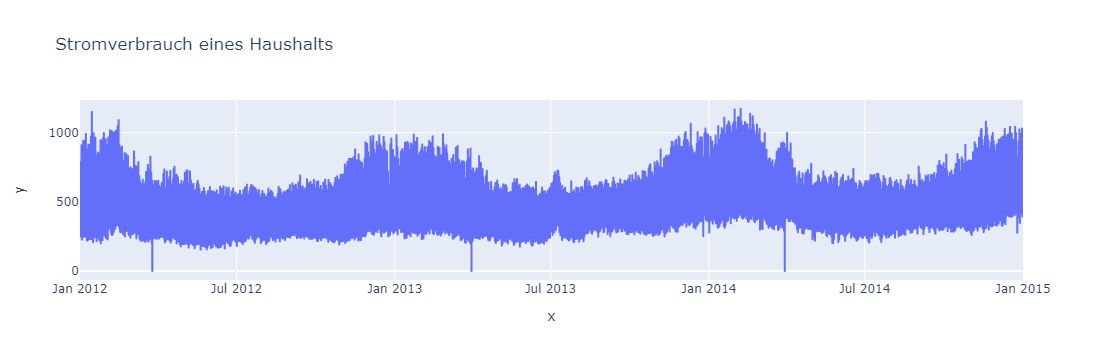

In [20]:
timef = pd.to_datetime(time.flatten()).tolist()
emaf = ema.flatten().tolist()
fig = px.line(x=timef, y=emaf, title='Stromverbrauch eines Haushalts', labels=dict(Datum="Stündliche Daten", value="Stromverbrauch in kWh", variable=""))
fig.show()

In [21]:
mean_value = np.mean(ema[ema != 0])
ema[ema == 0] = mean_value

In [22]:
scaler = MinMaxScaler()
scaler.fit(ema)
emas = scaler.transform(ema)

In [23]:
emas.shape

(26304, 1)

C:\Users\hubersi\.conda\envs\foem24\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



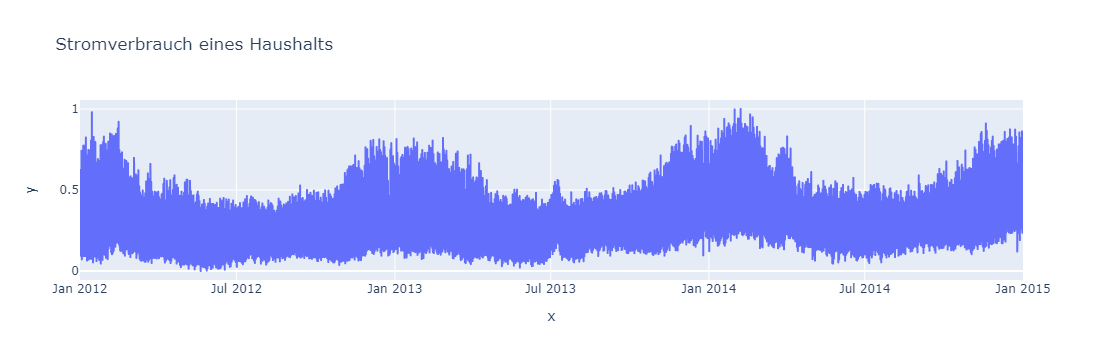

In [24]:
emasf = emas.flatten().tolist()
fig = px.line(x=timef, y=emasf, title='Stromverbrauch eines Haushalts', labels=dict(Datum="Stündliche Daten", value="Stromverbrauch in kWh", variable=""))
fig.show()

#### Trainings-, Validierungs- und Testdaten separieren

In [25]:
data = emas

In [26]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)
test_size = int(len(data) * 0.1)

In [27]:
data_train, data_val, data_test = data[0:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

In [28]:
time_train = time[:train_size]
time_val = time[train_size:train_size+val_size]
time_test = time[train_size+val_size:]

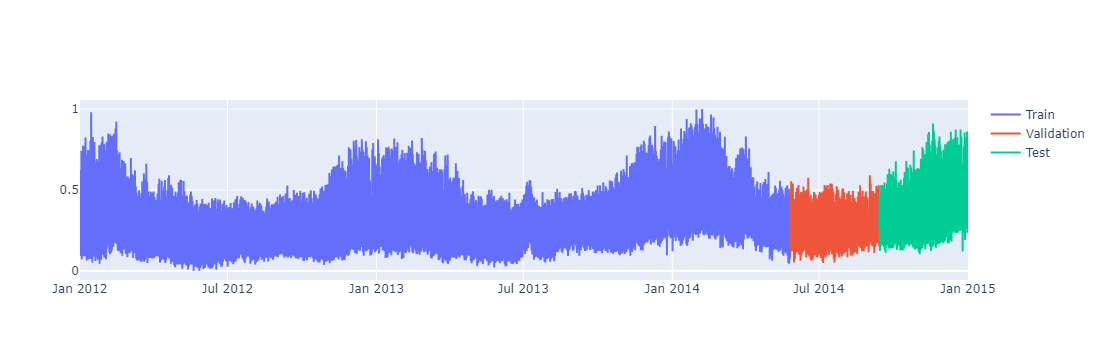

In [29]:
time_trainf = pd.to_datetime(time_train.flatten()).tolist()
time_valf = pd.to_datetime(time_val.flatten()).tolist()
time_testf = pd.to_datetime(time_test.flatten()).tolist()
dataf = data.flatten().tolist()
data_trainf = data_train.flatten().tolist()
data_valf = data_val.flatten().tolist()
data_testf = data_test.flatten().tolist()
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_trainf, y=data_trainf, mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=time_valf, y=data_valf, mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=time_testf, y=data_testf, mode='lines', name='Test'))
fig.show()

Wir vergleichen für alle Modelle die erste Woche der Testdaten als Input (168 Stunden) und die darauffolgenden 24 Stunden als Vorhersage.

In [62]:
start = pd.Timestamp('2014-09-13 09:00:00')
end = pd.Timestamp('2014-09-27 08:00:00')
short_data = em.loc[start:end]

In [63]:
short_data.head()

Stromverbrauch
Zeit                               
2014-09-13 09:00:00           430.0
2014-09-13 10:00:00           520.0
2014-09-13 11:00:00           515.0
2014-09-13 12:00:00           512.0
2014-09-13 13:00:00           537.0

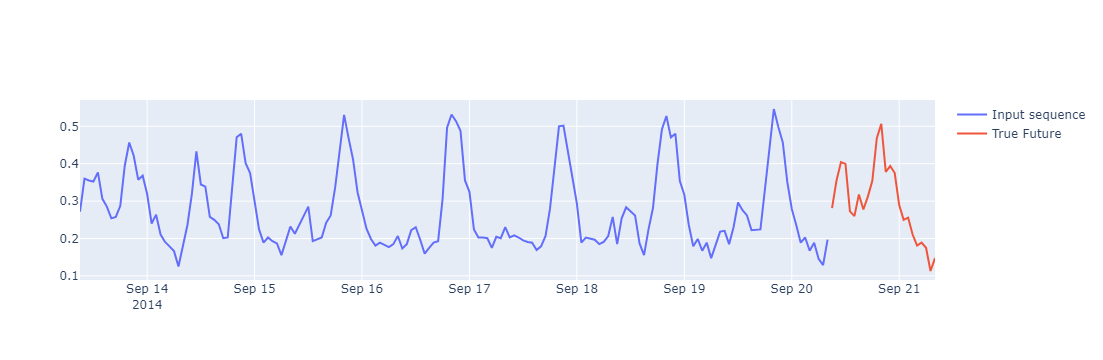

In [64]:
fig = go.Figure()

time_steps_X = pd.to_datetime(time_test[:168].flatten()).tolist()
time_steps_y = pd.to_datetime(time_test[168:192].flatten()).tolist()

fig.add_trace(go.Scatter(x=time_steps_X, y=knownwindow.flatten().tolist(), mode='lines', name='Input sequence'))
fig.add_trace(go.Scatter(x=time_steps_y, y=tobepred.flatten().tolist(), mode='lines', name='True Future'))

fig.show()

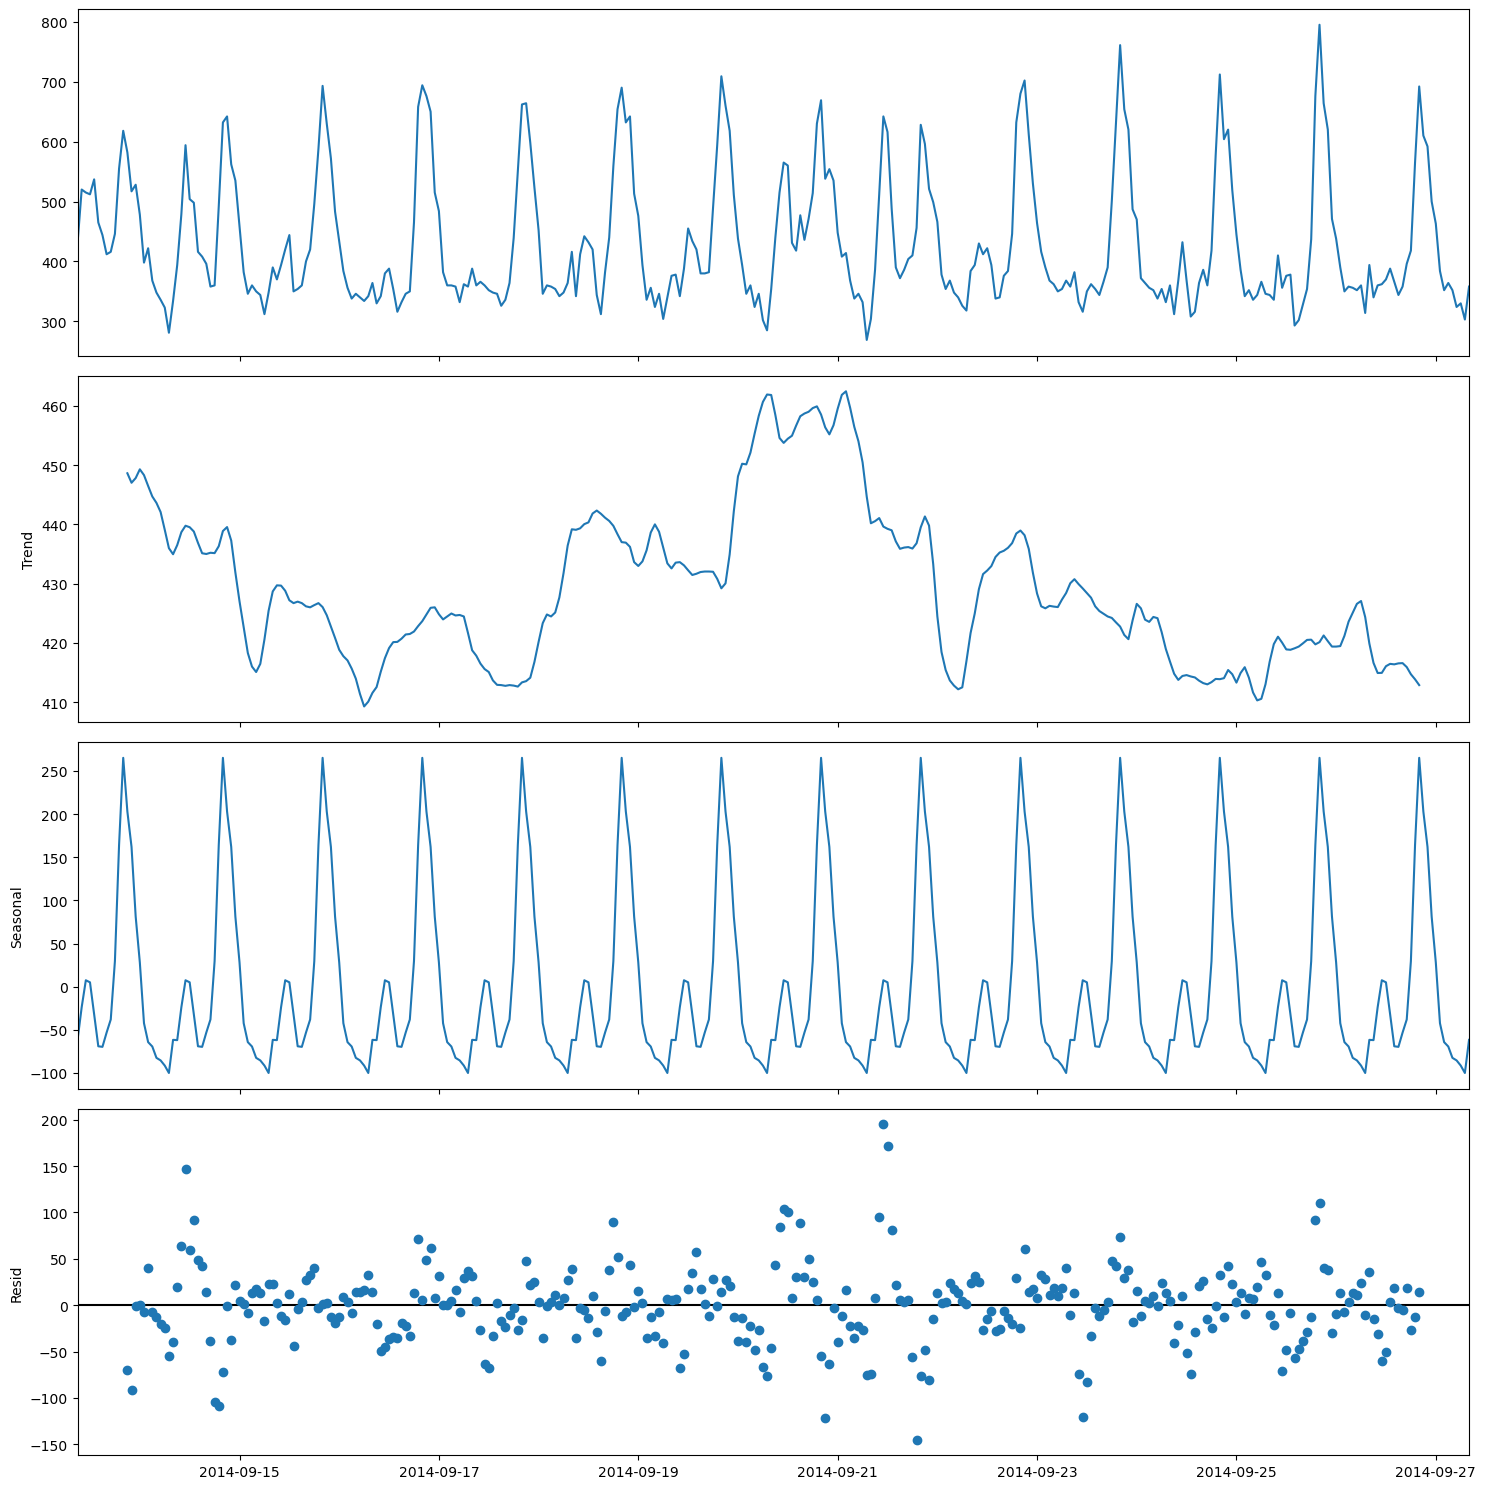

In [65]:
decomp = seasonal_decompose(short_data, model='additive')
fig = decomp.plot()
fig.set_size_inches((15, 15))
fig.tight_layout()

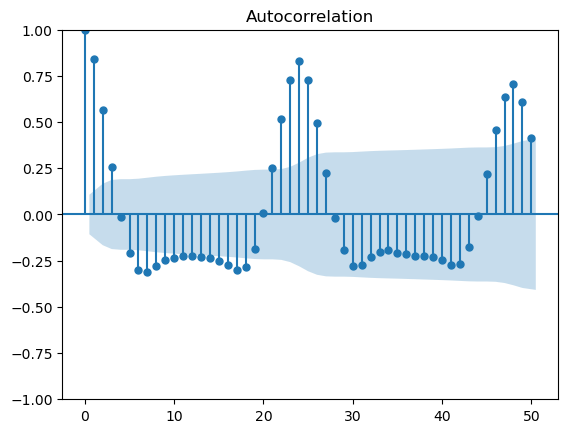

In [66]:
ACF = plot_acf(short_data, lags=50)

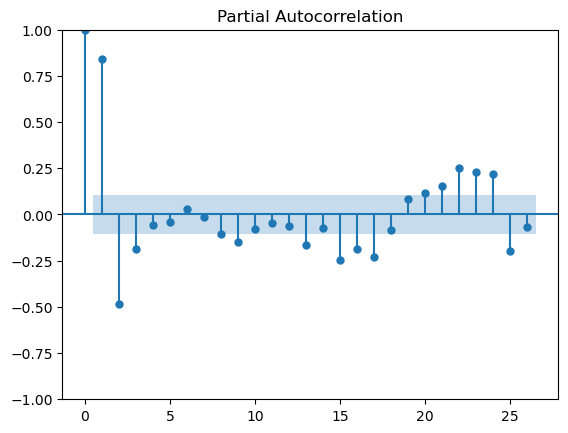

In [67]:
PACF = plot_pacf(short_data)

<div class="alert alert-info">
    <h5> Aufgabe: Jetzt bist du dran. </h5><br>
   Mach die Datenvorverarbeitung für einen anderen Haushalt aus dem Datensatz. Vielleicht findest du einen, der interessante Muster aufweist.
</div>

### 3.2 ARIMA Vorhersage

In [30]:
result = adfuller(data_train)
p_value = result[1]
if p_value <= 0.05:
    print("Die Daten sind wahrscheinlich stationär.")
else:
    print("Die Daten sind wahrscheinlich nicht stationär.")

Die Daten sind wahrscheinlich stationär.


In [31]:
data_train.shape

(21043, 1)

In [32]:
data_arima = data_train[20875:]
data_arima.shape

(168, 1)

In [33]:
model_arima = auto_arima(data_arima, seasonal=True, m=24, d=0, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-591.902, Time=1.12 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-273.754, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-569.357, Time=0.54 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-490.141, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=59.758, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=-541.059, Time=0.94 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-524.438, Time=1.22 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=-583.466, Time=14.48 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=-593.450, Time=12.47 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=inf, Time=9.02 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=-591.492, Time=12.83 sec
 ARIMA(1,0,2)(1,0,2)[24] intercept   : AIC=-592.218, Time=11.96 sec
 ARIMA(2,0,1)(1,0,2)[24] intercept   : AIC=-596.290, Time=12.69 sec
 ARIMA(2,0,1)(0,0,2)[24] intercept   : AIC=inf, Time=8.57 sec
 ARIMA(2,0,1)(1,0,1)[24] i

In [34]:
model_arima.fit(data_arima)

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(1, 0, 2, 24),
      suppress_warnings=True)

In [35]:
knownwindow = data_test[:168]
tobepred = data_test[168:192]

In [36]:
predictions_arima = model_arima.predict(n_periods=len(tobepred))

In [37]:
#training = knownwindow.copy()
#predictions_arima = []
#for i in range(len(tobepred)):
#    model_arima.fit(training[:len(training)+i])
#    next_prediction = model_arima.predict(n_periods=1)[0]
#    predictions_arima.append(next_prediction)
#    training = np.append(training, tobepred[i])

In [38]:
predictions_arima

array([0.35359029, 0.36255236, 0.36121677, 0.3708963 , 0.37214503,
       0.3477909 , 0.2595987 , 0.23939224, 0.2078572 , 0.20053068,
       0.16114729, 0.09848985, 0.15332704, 0.19076389, 0.21331219,
       0.31813786, 0.38557153, 0.32803699, 0.28168657, 0.25099365,
       0.24087411, 0.23143138, 0.25208953, 0.26846925])

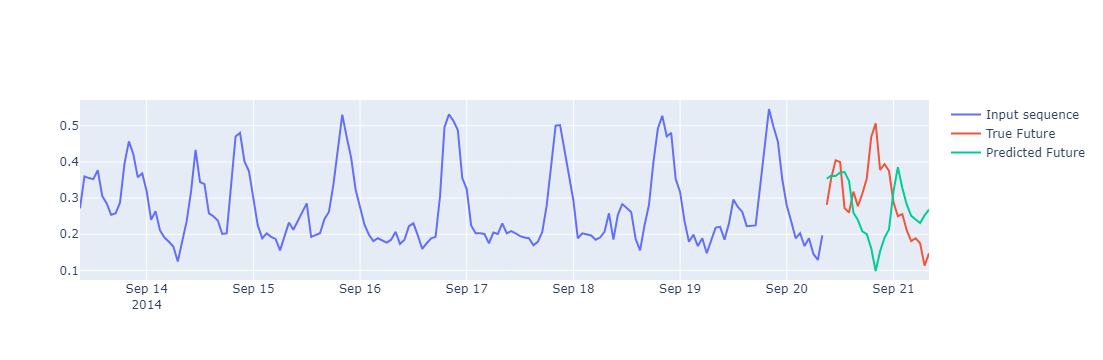

In [39]:
fig = go.Figure()

time_steps_X = pd.to_datetime(time_test[:168].flatten()).tolist()
time_steps_y = pd.to_datetime(time_test[168:192].flatten()).tolist()

fig.add_trace(go.Scatter(x=time_steps_X, y=knownwindow.flatten().tolist(), mode='lines', name='Input sequence'))
fig.add_trace(go.Scatter(x=time_steps_y, y=tobepred.flatten().tolist(), mode='lines', name='True Future'))
fig.add_trace(go.Scatter(x=time_steps_y, y=predictions_arima, mode='lines', name='Predicted Future'))

fig.show()

In [40]:
mse_ARIMA = round(mean_squared_error(tobepred, predictions_arima),4)
print('Test MSE ARIMA: ', mse_ARIMA)

Test MSE ARIMA:  0.0216


<div class="alert alert-info">
    <h5> Aufgabe: Jetzt bist du dran. </h5><br>
    Erstelle ein ARIMA-Modell für einen anderen Haushalt aus dem Datensatz - und einen anderen Zeithorizont
</div>

### 3.3 Prophet Vorhersage

In [41]:
data_dict = {'time': time.flatten(), 'data': data.flatten()}
df = pd.DataFrame(data_dict)
df.head()

time      data
0 2012-01-01 00:00:00  0.256890
1 2012-01-01 01:00:00  0.395669
2 2012-01-01 02:00:00  0.399606
3 2012-01-01 03:00:00  0.284449
4 2012-01-01 04:00:00  0.188976

In [42]:
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])
df['ds'].freq = 'H'
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [43]:
train_df = df[0:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

In [68]:
model_P = Prophet()

AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [ ]:
model_P.fit(train_df)

In [ ]:
pred_P = model_P.predict(test_df)
pred_P.tail()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df['ds'], y=train_df['y'], mode='lines', name='TRAIN'))
fig.add_trace(go.Scatter(x=val_df['ds'], y=val_df['y'], mode='lines', name='VAL'))
fig.add_trace(go.Scatter(x=test_df['ds'], y=test_df['y'], mode='lines', name='TEST'))
fig.add_trace(go.Scatter(x=pred_P['ds'], y=pred_P['yhat'], mode='lines', name='PROPHET'))
fig.show()

In [ ]:
fig = go.Figure()
#fig.add_trace(go.Scatter(x=train_df['ds'], y=train_df['y'], mode='lines', name='TRAIN'))
#fig.add_trace(go.Scatter(x=val_df['ds'], y=val_df['y'], mode='lines', name='VAL'))
fig.add_trace(go.Scatter(x=time_steps_X+time_steps_y, y=test_df['y'], mode='lines', name='TEST'))
fig.add_trace(go.Scatter(x=time_steps_y, y=pred_P['yhat'], mode='lines', name='PROPHET'))
fig.show()

<div class="alert alert-info">
    <h5> Aufgabe: Jetzt bist du dran. Rechne den Modellvergleich für einen anderen Haushalt aus dem Datensatz</h5><br>
- Passe die Eingaben, das Modell und die Hyperparameter an.<br>
    - Was passiert, wenn du weniger Daten in ein Fenster nimmst? Oder mehr?<br>
</div>

In [ ]:
#Dein Code